In [1]:
#pyTorch

import azureml.core
print(azureml.core.VERSION)
from azureml.core.workspace import Workspace
ws = Workspace.from_config()
ws.get_details()

from azureml.core import Environment

curated_env = Environment.get(workspace=ws, name="abi_pytorch2")



1.51.0


In [4]:
%pip install torch


Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement rTorch (from versions: none)
ERROR: No matching distribution found for rTorch
Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy
import pandas
import matplotlib.pyplot
import csv
import torch
import math
import torch.nn as nn

Load data, make into tensors...

In [3]:
schools = pandas.read_csv("/home/azureuser/cloudfiles/code/Users/ariley/Data/Schools/School_Counts/ceara_school_count_data.csv")

schools = schools.iloc[:, 3:]

schools = schools.dropna()

schools.head()

,NUMPOINTS,ID,land,pop,built_s,built_v,smod,x,y
0,0,1.0,1000000.0,0.000000,0,0,11,-4.146928e+06,-415647.743962
1,0,2.0,1000000.0,0.000000,0,0,11,-4.146995e+06,-416168.514849
2,0,3.0,1000000.0,89.137142,4644,11618,12,-4.145898e+06,-412699.018444
3,0,4.0,1000000.0,8.601842,359,898,11,-4.146006e+06,-413307.519153
4,0,5.0,1000000.0,2.825484,141,353,11,-4.146103e+06,-414290.948276


In [4]:
schools.NUMPOINTS.describe()

count    151221.000000
mean          0.094993
std           1.057113
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         198.000000
Name: NUMPOINTS, dtype: float64

In [30]:
mu_ = schools.NUMPOINTS.mean()
sigma_ = numpy.sqrt(schools.NUMPOINTS.var())

https://github.com/meaneych/PyTorch_CountDistribution_Examples/blob/main/Poisson_PyTorch_Autograd.ipynb

In [31]:
x = torch.autograd.Variable(torch.from_numpy(schools.to_numpy())).type(torch.FloatTensor)
l_mu = torch.autograd.Variable(torch.rand(1), requires_grad=True) 

Poisson Loss Functions

In [15]:
def poisson_nll(x, log_mu):
    nll = -torch.sum(-torch.exp(log_mu) + x*torch.log(torch.exp(log_mu)) - torch.lgamma(x))
    return nll

In [ ]:
def poissonLoss(predicted, observed):
    """Custom loss function for Poisson model."""
    loss = torch.mean(predicted-observed*torch.log(predicted))
    return loss

pyTorch ZIP loss function????

mixture loss function??? possible?

In [ ]:
def poisson_nll(x, log_mu):
    if x == 0:
        nll = 
    nll = -torch.sum(-torch.exp(log_mu) + x*torch.log(torch.exp(log_mu)) - torch.lgamma(x))
    return nll

From ChatGPT

In [34]:
class ZeroInflatedPoissonLoss(torch.nn.Module):
    def __init__(self):
        super(ZeroInflatedPoissonLoss, self).__init__()

    def forward(self, y_true, pi, lambda_param):
        """
        Args:
            y_true (torch.Tensor): True target values (ground truth).
            pi (torch.Tensor): Probability of excess zeros (0 <= pi <= 1).
            lambda_param (torch.Tensor): Poisson distribution parameter.
        """
        # Calculate the probability mass function for each data point
        prob_zero = pi + (1 - pi) * torch.exp(-lambda_param)
        prob_non_zero = (1 - pi) * torch.exp(-lambda_param) * lambda_param**y_true / torch.factorial(y_true)

        # Combine the probabilities for zero and non-zero values
        prob_combined = torch.where(y_true == 0, prob_zero, prob_non_zero)

        # Calculate the negative log-likelihood
        loss = -torch.log(prob_combined)

        # Take the mean across the batch
        nll = torch.mean(loss)

        return nll

In [32]:
## Learning rate
learning_rate = 2e-4

## Training loop
for t in range(100):
    ## Backprop on negative log likelihood loss
    loss = nn.PoissonNLLLoss()
    NLLp = loss(l_mu, x)
    NLLp.backward()
    ## Logging to console
    if t % 10 == 0:
        print("Iteration = ", t, 
              "loglik  =", NLLp.data.numpy(), 
              "l_mu =", l_mu.data.numpy(), 
              "dL/dlmu = ", l_mu.grad.data.numpy())
    ## SGD update of parms
    l_mu.data -= learning_rate * l_mu.grad.data
    ## Zero the gradients
    l_mu.grad.data.zero_()

Iteration =  0 loglik  = 35229.46 l_mu = [0.09053355] dL/dlmu =  [389120.53]
Iteration =  10 loglik  = -302792670.0 l_mu = [-778.14844] dL/dlmu =  [389119.44]
Iteration =  20 loglik  = -605620350.0 l_mu = [-1556.387] dL/dlmu =  [389119.44]
Iteration =  30 loglik  = -908448300.0 l_mu = [-2334.626] dL/dlmu =  [389119.44]
Iteration =  40 loglik  = -1211276500.0 l_mu = [-3112.8657] dL/dlmu =  [389119.44]
Iteration =  50 loglik  = -1514104600.0 l_mu = [-3891.1055] dL/dlmu =  [389119.44]
Iteration =  60 loglik  = -1816932000.0 l_mu = [-4669.3433] dL/dlmu =  [389119.44]
Iteration =  70 loglik  = -2119759500.0 l_mu = [-5447.5806] dL/dlmu =  [389119.44]
Iteration =  80 loglik  = -2422586400.0 l_mu = [-6225.818] dL/dlmu =  [389119.44]
Iteration =  90 loglik  = -2725414000.0 l_mu = [-7004.055] dL/dlmu =  [389119.44]


In [33]:
## Final estimate of Poisson mean parm
[l_mu.data.numpy(), numpy.exp(l_mu.data.numpy())]

[array([-7782.2925], dtype=float32), array([0.], dtype=float32)]

Now let's try with just urban maybe?

(array([546.,  18.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  19.8,  39.6,  59.4,  79.2,  99. , 118.8, 138.6, 158.4,
        178.2, 198. ]),
 <a list of 10 Patch objects>)

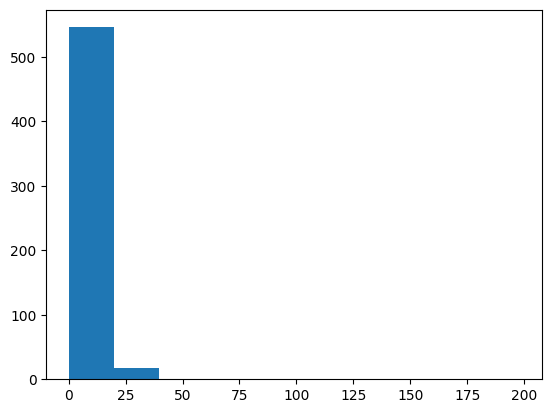

In [59]:
schools = pandas.read_csv("/home/azureuser/cloudfiles/code/Users/ariley/Data/Schools/School_Counts/ceara_school_count_data.csv")
schools = schools.iloc[:, 3:]
schools = schools.dropna()
#schools = schools[schools["smod"].isin([21,22,23,30])]
schools = schools[schools["smod"] == 30]

schools.head()
matplotlib.pyplot.hist(schools.NUMPOINTS)

In [53]:
mu_ = schools.NUMPOINTS.mean()
sigma_ = numpy.sqrt(schools.NUMPOINTS.var())

x = torch.autograd.Variable(torch.from_numpy(schools.to_numpy())).type(torch.FloatTensor)
l_mu = torch.autograd.Variable(torch.rand(1), requires_grad=True) 

## Learning rate
learning_rate = 2e-4

## Training loop
for t in range(100):
    ## Backprop on negative log likelihood loss
    loss = nn.PoissonNLLLoss()
    NLLp = loss(l_mu, x)
    NLLp.backward()
    ## Logging to console
    if t % 10 == 0:
        print("Iteration = ", t, 
              "loglik  =", NLLp.data.numpy(), 
              "l_mu =", l_mu.data.numpy(), 
              "dL/dlmu = ", l_mu.grad.data.numpy())
    ## SGD update of parms
    l_mu.data -= learning_rate * l_mu.grad.data
    ## Zero the gradients
    l_mu.grad.data.zero_()

Iteration =  0 loglik  = 30012.994 l_mu = [0.31442636] dL/dlmu =  [95450.17]
Iteration =  10 loglik  = -18190966.0 l_mu = [-190.58344] dL/dlmu =  [95448.805]
Iteration =  20 loglik  = -36411908.0 l_mu = [-381.48096] dL/dlmu =  [95448.805]
Iteration =  30 loglik  = -54632860.0 l_mu = [-572.3786] dL/dlmu =  [95448.805]
Iteration =  40 loglik  = -72853840.0 l_mu = [-763.2764] dL/dlmu =  [95448.805]
Iteration =  50 loglik  = -91074780.0 l_mu = [-954.17426] dL/dlmu =  [95448.805]
Iteration =  60 loglik  = -109295736.0 l_mu = [-1145.0717] dL/dlmu =  [95448.805]
Iteration =  70 loglik  = -127516610.0 l_mu = [-1335.9689] dL/dlmu =  [95448.805]
Iteration =  80 loglik  = -145737580.0 l_mu = [-1526.8661] dL/dlmu =  [95448.805]
Iteration =  90 loglik  = -163958380.0 l_mu = [-1717.7633] dL/dlmu =  [95448.805]


In [54]:
## Final estimate of Poisson mean parm
[l_mu.data.numpy(), numpy.exp(l_mu.data.numpy())]

[array([-1908.6605], dtype=float32), array([0.], dtype=float32)]